In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline
import numpy as np 
import crossover
import selection

Populating the interactive namespace from numpy and matplotlib


## Using the Genetic Algorithm

Following the No Free Lunch Theorem, we should know that sometimes, we do not know the best method to use a-priori. However, a general rule of thumb is that the Genetic Algorithm is useful for problems where we have few feasible design points where the feasible region is scattered about the domain of our cost or objective function. An example of such a problem is the 0/1 Knapsack problem. 

In the 0/1 Knapsack problem we envision a thief breaking into a musuem to steal artifacts. They are wearing a single knapsack that they plan to use to carry out of all of the artifacts they are attempting to steal. They know the value of each artifact in the musuem, and want to steal the most profitable combination of artifacts that they can fit into their knapsack. While this may seem a sort of sordid problem, the general mathematical formulation of the 0/1 Knapasck problem is applicable to many different types of problems. As it turns out the 0/1 Knapsack problem is NP Complete - meaning it is among the hardest problems in the computational class NP. There exists a psuedopolynomial time dynamic programming algorithm to solve it, and several greedy approximation strategies, but today we will see how the genetic algorithm can help us solve it

### Mathematical formulation

Let's formulate the 0/1 Knapsack problem a bit. We have items labeled $1, 2, \cdots, n$ with profit values encoded in a vector $p$ where $p_i$ is the value of item $i$, and weights encoded in a vector $w$ where $w_i$ is the weight of item $i$. We have a knapsack of capacity $C \in \mathbb{Z}$. For item $i$, we encode the decision to take it in $x_i \in \{0, 1\}$ which is a component of a vector $x$. The 0/1 Knapsack problem can be formalised as follows:

$$\max_{x} p^{T}x$$
subject to 
$$w^{T}x \leq C$$
$$\forall i \in \{1, 2, \cdots, n\}, x_{i} \in \{0, 1\}$$

### Genetic Operators
Given the formulation we need to choose our genetic operators and representation scheme. 
First, lets choose our representation scheme as all other decisions we make are contingent on it. Since we have to make a finite number of yes (1)/no (0) decisions, we can use a bit-array as our representation for a chromosome.

Mutation is simple, we simply randomly choose a point and flip the value.

For crossover, we can choose any one of single-point, multiple-point, or uniform crossovers. Interpolation would not work as our design points are in a discrete rather than a continuous space. 

For selection methodology, we can use any methodology, but in practice, Roulette Wheel tends to perform best with such cases.

Our fitness function is a little tricky. If a chromosome is in violation of the specification, we can either set fitness to 0 and eradicate from our population, or we can simply penalise the solution. The later is simplier in this case, so we will try that.

We need to choose hyperparamters as well: let $k = 100, e = 5, p_c = 0.8, p_m = 0.05$

In [104]:
## Let's store the data for the problem
n = 100
p = np.random.randint(5, 8, size=n)
w = np.random.randint(10, 45, size=n)
C = 365

## Store hyperparamters:
p_c = 0.8
p_m = 0.1
k = 100
e = 5
num_iter = 100

convergence_curve = []

In [105]:
def compute_penalty(x):
    total_weight = np.dot(w, x)
    penalty = np.maximum(0, -C + total_weight)
    return penalty
    
def fitness(x):
    profit = np.dot(p, x)
    penalty = compute_penalty(x) # we apply a penalty for how much extra weight above capacity a solution incurs
    return profit - penalty

def mutate(x):
    point = np.random.randint(1, len(x))
    x[point] = 1 - x[point]
    return x

In [106]:
population = np.random.randint(0, 2, size=(k, n))
fitnesses = np.array([fitness(x) for x in population])
selector = selection.RouletteWheelSelector()

In [107]:
for i in range(num_iter):
    convergence_curve.append(max(fitnesses))
    new_population = selection.elitism(e, population, fitnesses)
    selector.prep_selector(fitnesses)
    while len(new_population) < k:
        parent1, parent2 = selector.select(population)
        perform_crossover = np.random.random() <= p_c
        if perform_crossover:
            child = crossover.single_point(parent1, parent2)
            perform_mutation = np.random.random() <= p_m
            if perform_mutation:
                child = mutate(child)
            new_population = np.append(new_population, [child], axis=0)
    population = new_population
    fitnesses = np.array([fitness(x) for x in population])

In [108]:
best = selection.elitism(1, population, fitnesses)[0]

In [109]:
best

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1])

In [110]:
fitness(best)

123

In [111]:
compute_penalty(best)

0

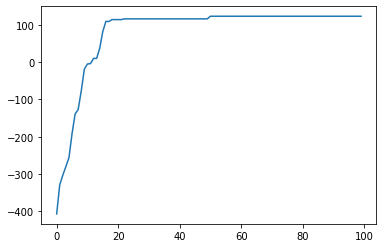

In [112]:
plot(list(range(len(convergence_curve))), convergence_curve)

Plotting a curve of objective function value vs iteration gives us a sense as to how well the algorithm is performing